In [1]:
from typing import Any, Callable, Generator, List, NamedTuple, Optional, Tuple

import h5py
import enum
import operator
from pathlib import Path

import functools as ft
import itertools as it

import numpy as np

import einops
import opt_einsum as oe

import torch
from torch import nn

# plotting uti
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import ImageGrid

# special colourmap
from seaborn.cm import icefire

# loading from library
from picr.model import Autoencoder

from picr.utils.config import ExperimentConfig
from picr.utils.enums import eSolverFunction
from picr.utils.loss_tracker import LossTracker
from picr.experiments.data import generate_dataloader

In [2]:
def prepare_latex() -> None:
    
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'Times New Roman',
        'font.size' : 10,
    })

    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{nicefrac}\usepackage{bm}')
    
prepare_latex()

In [3]:
EXPERIMENT_DIR = Path.cwd() / 'src' / 'experiments'

FREQ_EXPERIMENTS = EXPERIMENT_DIR / 'FREQ'
MAG_EXPERIMENTS = EXPERIMENT_DIR / 'MAG'

In [4]:
class Run:
    
    def __init__(self, run_path: Path) -> None:
        
        self.run_path = run_path
        
        # define relevant paths
        self.results_path = self.run_path / 'results.csv'
        self.model_path = self.run_path / 'autoencoder.pt'
        self.config_path = self.run_path / 'config.yml'
        self.inference_path = self.run_path / 'inference.h5'
        
        # load config
        self.config: ExperimentConfig = self._load_config(self.config_path)
        
    def __repr__(self) -> str:
        return f'Run(system={self.system.name}, freq={self.frequency}, mag={self.magnitude}, idx={self.run_path.name})'
    
    @property
    def system(self) -> eSolverFunction:
        return self.config.SOLVER_FN
    
    @property
    def frequency(self) -> float:
        return self.config.PHI_FREQ

    @property
    def magnitude(self) -> float:
        return self.config.PHI_LIMIT
    
    @staticmethod
    def _load_config(config_path: Path) -> ExperimentConfig:
        
        _config = ExperimentConfig()
        _config.load_config(config_path)
        
        return _config
    
    def load_results(self) -> np.ndarray:
        return np.loadtxt(self.results_path, delimiter=',', skiprows=1)

In [5]:
def generate_eResults() -> enum.EnumMeta:
    
    lt = LossTracker()
    
    str_list = ['epoch', *lt.get_fields(training=True), *lt.get_fields(training=False)]
    str_list = list(map(lambda x: x.upper(), str_list))
    
    return enum.IntEnum('eResults', str_list, start=0)

class eExperimentType(enum.Enum):
    FREQUENCY = 'FREQ'
    MAGNITUDE = 'MAG'
    
eResults = generate_eResults()

In [6]:
def get_glob(experiment_type: eExperimentType) -> str:
    
    if experiment_type == eExperimentType.FREQUENCY:
        return './FREQ*/*'
    
    if experiment_type == eExperimentType.MAGNITUDE:
        return './MAG*/*'
    
    raise KeyError('Invalid eExperimentType')

In [7]:
class BaseExperiment:
    
    experiment_type: eExperimentType
    
    def __init__(self, experiment_path: Path) -> None:
        
        self.experiment_path = experiment_path
        
        # load all runs in experiment
        self._run_paths = list(self.experiment_path.glob(self._glob_factory(self.experiment_type)))
        
        # create a Run for each of the run_paths
        self.runs = [Run(run_path=i) for i in self._run_paths]
        
        self.frequencies = sorted(set([run.frequency for run in self.runs]))
        self.magnitudes = sorted(set([run.magnitude for run in self.runs]))
        
    @staticmethod
    def _glob_factory(experiment_type: eExperimentType) -> str:
        
        factory = {
            eExperimentType.FREQUENCY: './FREQ*/*',
            eExperimentType.MAGNITUDE: './MAG*/*'
        }
        
        return factory[experiment_type]
        
    def __iter__(self) -> Generator[Run, None, None]:
        for run in self.runs:
            yield run
 
    @property
    def name_observable(self) -> str:
        return self._get_obs_fixed_names()[0]

    @property
    def name_fixed(self) -> str:
        return self._get_obs_fixed_names()[1]
    
    def _get_obs_fixed_names(self) -> tuple[str]:
        
        factory = {
            eExperimentType.FREQUENCY: ['f', 'M'],
            eExperimentType.MAGNITUDE: ['M', 'f']
        }
        
        return factory[self.experiment_type]
    
    def get_fixed(self) -> float:
        
        val: set
        if self.experiment_type == eExperimentType.FREQUENCY:
            val = self.magnitudes
        else:
            val = self.frequencies
            
        if not len(val) == 1:
            raise ValueError('Not fixed parameter...')
            
        return val[0]   
        
    @property
    def observables(self) -> Generator[float, None, None]:
        raise ValueError('Must implement BaseExperiment::observables()')
        
    @property
    def n_runs(self) -> int:
        return len(self.runs)
    
    @property
    def n_frequencies(self) -> int:
        return len(self.frequencies)
    
    @property
    def n_magnitudes(self) -> int:
        return len(self.magnitudes)
    
    @staticmethod
    def filter_observables(run: Run, val_observable: float) -> bool:
        raise ValueError('Must overrise BaseExperiment::filter_fn()')
    
        
class FrequencyExperiment(BaseExperiment):
    
    experiment_type: eExperimentType = eExperimentType.FREQUENCY
    
    def __init__(self, experiment_path: Path) -> None:
        super().__init__(experiment_path)
            
    @property
    def observables(self) -> Generator[float, None, None]:
        for frequency in self.frequencies:
            yield frequency
            
    @staticmethod
    def filter_observables(run: Run, val_observable: float) -> bool:
        return run.frequency == val_observable
       
    
class MagnitudeExperiment(BaseExperiment):
    
    experiment_type: eExperimentType = eExperimentType.MAGNITUDE
    
    def __init__(self, experiment_path: Path) -> None:
        super().__init__(experiment_path)
        
    @property
    def observables(self) -> Generator[float, None, None]:
        for mag in self.magnitudes:
            yield mag
                    
    @staticmethod
    def filter_observables(run: Run, val_observable: float) -> bool:
        return run.magnitude == val_observable

**Defining Experiments:**

In [8]:
class FrequencyMagnitudePair(NamedTuple):
    frequency_experiment: FrequencyExperiment
    magnitude_experiment: MagnitudeExperiment

In [9]:
class eSystemName(enum.Enum):
    LINEAR = 'LINEAR'
    NONLINEAR = 'NONLINEAR'
    KOLMOGOROV = 'KOLMOGOROV'

In [10]:
EXPERIMENT_PATHS = {
    experiment_type: {sys: base_path / sys.value for sys in eSystemName} 
    for base_path, experiment_type in zip((FREQ_EXPERIMENTS, MAG_EXPERIMENTS), (eExperimentType.FREQUENCY, eExperimentType.MAGNITUDE))
}

def get_experiment_path(experiment_type: eExperimentType, system_type: eSystemName) -> Path:
    return EXPERIMENT_PATHS[experiment_type][system_type]

In [11]:
experiment_factory = {
    eExperimentType.FREQUENCY: FrequencyExperiment,
    eExperimentType.MAGNITUDE: MagnitudeExperiment
}


def get_all_experiments():
    
    experiment_dict = {}
    for e_type in eExperimentType:
        
        sys_dict = {}
        e_module = experiment_factory[e_type]
        for sys_type in eSystemName:
            path = get_experiment_path(e_type, sys_type)
            sys_dict[sys_type] = e_module(path)
            
        experiment_dict[e_type] = sys_dict
        
    return experiment_dict


def get_experiment_list(experiment_dict: dict[eExperimentType, dict[eSystemName, FrequencyExperiment | MagnitudeExperiment]]):
    
    e_list = []
    for e_dict in experiment_dict.values():
        for system in e_dict.values():
            e_list.append(system)
            
    return e_list


experiment_dict = get_all_experiments()
experiment_list = get_experiment_list(experiment_dict)


def get_experiment(e_type: eExperimentType, sys_type: eSystemName):
    return experiment_dict[e_type][sys_type]

**Plotting Training Curves:**

In [12]:
def get_cmap(n: int, name: str = 'viridis'):
    return plt.cm.get_cmap(name, n)

Text(0, 0.5, 'Kolmogorov')

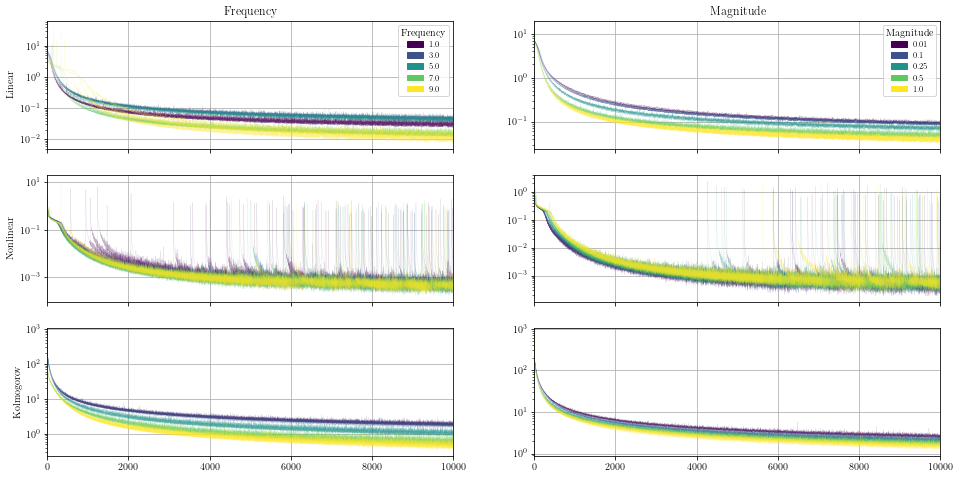

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(16, 8), sharex=True, facecolor='white')
axs = axs.T.flatten()

for e_idx, experiment in enumerate(experiment_list):
    
    ax = axs[e_idx]
    
    legend_patches = []

    cmap = get_cmap(len(list(experiment.observables)))
    for idx, f in enumerate(experiment.observables):
        
        legend_entry = False

        partial_filter_obs = ft.partial(experiment.filter_observables, val_observable=f)
        for run in filter(partial_filter_obs, experiment):

            results = run.load_results()
            ax.plot(results[:, eResults.EPOCH], results[:, eResults.TRAIN_TOTAL_LOSS], c=cmap(idx), linewidth=0.2, alpha=0.3)

            if not legend_entry:
                patch = mpatches.Patch(color=cmap(idx), label=f'{f}')
                legend_patches.append(patch)

                legend_entry = True
                
    title = {
        FrequencyExperiment: 'Frequency',
        MagnitudeExperiment: 'Magnitude'
    }[type(experiment)]
    
    if e_idx == 0 or e_idx == 3:
        ax.legend(handles=legend_patches, title=title, title_fontsize=10, fontsize=8)
    
for ax in axs:
    
    ax.set_yscale('log')
        
    # ax.set_ylim(10 ** -3, 10 ** 1)
    ax.set_xlim(0, 10_000)
    
    ax.grid()

axs[0].set_title('Frequency')
axs[3].set_title('Magnitude')

axs[0].set_ylabel('Linear')
axs[1].set_ylabel('Nonlinear')
axs[2].set_ylabel('Kolmogorov')

In [14]:
@ft.lru_cache()
def extract_mu_sigma(experiment: BaseExperiment, column: eResults) -> Tuple[List[float], List[float]]:
    
    """Extracts best mu, sigma from a given column for an experiment.
    
    Parameters:
    -----------
    experiment: BaseExperiment
        An instance of the experiment
    """
    
    mus = {}
    sigmas = {}
    
    for idx, observable in enumerate(experiment.observables):
                
        partial_filter_obs = ft.partial(experiment.filter_observables, val_observable=observable)
        runs = list(filter(partial_filter_obs, experiment))
        
        # load results in and index by column
        results = np.stack([run.load_results() for run in runs], axis=0)
        results = results[..., column]
        
        # locate the best results for each run
        best_result_idx = np.argmin(results, axis=1, keepdims=True)
        results = np.take_along_axis(results, best_result_idx, axis=1)
        
        # find the mean and std of these results
        mu_results = np.mean(results)
        sigma_results = np.std(results)
        
        mus[observable] = mu_results
        sigmas[observable] = sigma_results
        
    return mus, sigmas

## **Frequency Magnitude Plots**

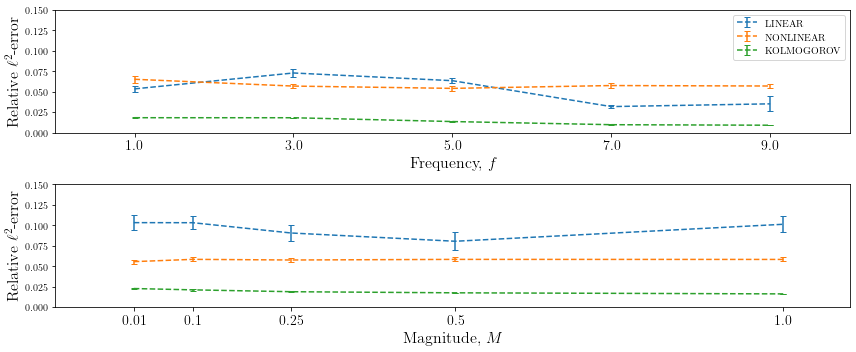

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5), facecolor='white')
axs = axs.flatten()

capsize = 3
column = eResults.VALIDATION_CLEAN_U_LOSS

for ax, e_type in zip(axs, eExperimentType):
    
    for sys_type, experiment in experiment_dict[e_type].items():
        mu, sigma = extract_mu_sigma(experiment, column=column)
        ax.errorbar(*zip(*mu.items()), yerr=list(sigma.values()), capsize=capsize, linestyle='--', label=sys_type.name)

        
axs[0].set_xlabel('Frequency, $f$', fontsize=16)
axs[1].set_xlabel('Magnitude, $M$', fontsize=16)

for ax in axs:
    ax.set_ylabel('Relative $\ell^2$-error', fontsize=16)

axs[0].set_ylim(0, 0.15)
axs[0].set_xlim(0, 10)
axs[0].set_xticks(list(get_experiment(eExperimentType.FREQUENCY, eSystemName.LINEAR).frequencies))
axs[0].set_xticklabels(list(get_experiment(eExperimentType.FREQUENCY, eSystemName.LINEAR).frequencies), fontsize=14)

axs[1].set_ylim(0, 0.15)
axs[1].set_xlim(-0.11, 1.101)
axs[1].set_xticks(list(get_experiment(eExperimentType.MAGNITUDE, eSystemName.LINEAR).magnitudes))
axs[1].set_xticklabels(list(get_experiment(eExperimentType.MAGNITUDE, eSystemName.LINEAR).magnitudes), fontsize=14)

axs[0].legend(loc='upper right')
fig.tight_layout()

In [16]:
def get_frequency_magnitude_pairs() -> tuple[FrequencyMagnitudePair, FrequencyMagnitudePair, FrequencyMagnitudePair]:
    return (FrequencyMagnitudePair(*(get_experiment(e_type, e_sys) for e_type in eExperimentType)) for e_sys in eSystemName)


fm_linear, fm_nonlinear, fm_kolmogorov = get_frequency_magnitude_pairs()

In [17]:
def freq_mag_plot(experiment_pair: FrequencyMagnitudePair, ylim: tuple[float, float] | None = None) -> plt.Figure:
    
    fig = plt.figure(figsize=(5.5, 1.2), facecolor='white')
    ax = fig.gca()

    capsize = 3
    column = eResults.VALIDATION_CLEAN_U_LOSS

    # frequency plots
    x_vals = np.arange(1, 5 + 1)
    
    for experiment, width in zip(reversed(experiment_pair), (0.8, 0.6)):
        mu, sigma = extract_mu_sigma(experiment, column=column)
        
        s_obs, s_fixed = experiment.name_observable, experiment.name_fixed
        val_fixed = experiment.get_fixed()
        
        ax_label = r'$\left.\kern-\nulldelimiterspace \mathcal{' + s_obs + r'} \vphantom{\big|} \right|_{' + f'{s_fixed} = {val_fixed}' + r'}$'
        ax.bar(x_vals, mu.values(), width=width, label=ax_label)
        
    # lower -- set frequency ticks
    ax.set_xticks(x_vals)
    ax.set_xticklabels(map(lambda x: fr'${x}$', [1, 3, 5, 7, 9]))

    # upper -- set magnitude ticks
    ax2 = ax.twiny()
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xbound(ax.get_xbound())
    ax2.set_xticklabels(map(lambda x: fr'${x}$', [0.01, 0.1, 0.25, 0.5, 1.0]))

    
    
    ax.set_ylabel(r'Relative $\ell^2$-error', fontsize=6, labelpad=8)

    # set tick params
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax2.tick_params(axis='both', which='major', labelsize=6)

    ax.grid(alpha=0.3)

    leg = ax.legend(fontsize=6, facecolor='white', framealpha=1, edgecolor='k')
    leg.get_frame().set_linewidth(0.1)
    leg.get_frame().set_boxstyle('square', pad=0.1)

    # set limits
    ax.set_xlim(-0.1, 5.5)
    ax2.set_xlim(-0.1, 5.5)
    
    if ylim:
        ax.set_ylim(*ylim)

    for axis, experiment, pad in zip((ax, ax2), experiment_pair, (0, 8)):
        
        s_obs, s_fixed = experiment.name_observable, experiment.name_fixed
        val_fixed = experiment.get_fixed()

        ax_label = r'$\left.\kern-\nulldelimiterspace \mathcal{' + s_obs + r'} \vphantom{\big|} \right|_{' + f'{s_fixed} = {val_fixed}' + r'}$'
        
        axis.set_xlabel(ax_label, labelpad=pad, fontsize=6)

    ax.xaxis.set_label_coords(0.055, -0.075)
    ax2.xaxis.set_label_coords(0.055, 1.125)


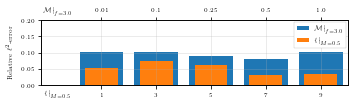

In [18]:
fig = freq_mag_plot(fm_linear, (0.0, 0.2))

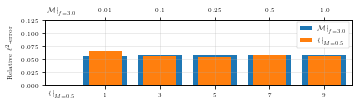

In [19]:
fig = freq_mag_plot(fm_nonlinear, (0.0, 0.125))

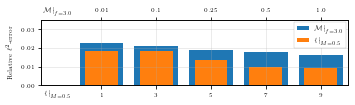

In [20]:
fig = freq_mag_plot(fm_kolmogorov, (0.0, 0.035))

## **Plot Flow Fields**

In [21]:
def assert_identical_shape(fn: Callable[[np.ndarray, ...], Any]) -> Callable[[np.ndarray, ...], Any]:
    
    @ft.wraps(fn)
    def _fn(*args, **kwargs):
        
        arg_chain = it.chain(args, kwargs.values())
        if not len(set([x.shape for x in arg_chain])) == 1:
            raise ValueError('Not all shapes of inputs are identical...')
        
        return fn(*args, **kwargs)
    
    return _fn

class assert_ndim:
    
    def __init__(self, ndim: int) -> None:
        self.ndim = ndim
        
    def __call__(self, fn: Callable[[np.ndarray, ...], Any]) -> Callable[[np.ndarray, ...], Any]:
        
        @ft.wraps(fn)
        def _fn(*args, **kwargs):
            
            arg_chain = it.chain(args, kwargs.values())
            if not all(map(lambda x: x.ndim == self.ndim, arg_chain)):
                raise ValueError(f'Not all arrays are {self.ndim}D...')
                
            return fn(*args, **kwargs)
    
        return _fn
    
def assert_dims_equal(fn: Callable[[np.ndarray, ...], Any]) -> Callable[[np.ndarray, ...], Any]:
    
    @ft.wraps(fn)
    def _fn(*args, **kwargs):
        
        arg_chain = it.chain(args, kwargs.values())
        shapes = [x.shape for x in arg_chain]
        if not all(np.equal(*shapes) for x in arg_chain):
            raise ValueError('Not all inputs have dimensions of equal length')
        
        return fn(*args, **kwargs)
    
    return _fn

In [22]:
@assert_dims_equal
@assert_identical_shape
@assert_ndim(ndim=2)
def paper_plot_results(*, corrupted_data: np.ndarray, clean_u: np.ndarray, predicted_u: np.ndarray, clean_phi: np.ndarray, predicted_phi: np.ndarray) -> plt.Figure:
    
    nx = corrupted_data.shape[0]
    cm = 'RdBu_r'
    
    # setup figure
    fig = plt.figure(figsize=(5.5, 5.5 / 2 + 0.1), constrained_layout=False, facecolor='white')
    
    ## PLOT ZETA #######################################################
    zeta_grid = ImageGrid(
        fig, 
        121, 
        nrows_ncols=(1, 1), 
        axes_pad=0.0, 
        share_all=True,
        label_mode='L',
        cbar_location='right',
        cbar_mode='single',
        cbar_pad='2%'
    )
    
    im = zeta_grid[0].imshow(corrupted_data, cmap=cm)
    
    cbar_ax = zeta_grid.cbar_axes[0]
    cbar = cbar_ax.colorbar(im)
    cbar_ax.tick_params(labelsize=6)

    # configure colourbar ticklabels
    cbar_ax.yaxis.set_ticks_position('right')
    cbar_ax.xaxis.set_ticklabels([])

    # set title
    zeta_grid[0].set_title(r'$\zeta(\bm{\Omega_{g}}, t)$', fontsize=6)
    
    # set aspect ratio
    zeta_grid[0].set_aspect('equal', 'box')

    ## PLOT RESULTS #######################################################
    results_grid = ImageGrid(
        fig, 
        122, 
        nrows_ncols=(2, 2), 
        axes_pad=0.3, 
        share_all=False,
        label_mode='L',
        cbar_location='right',
        cbar_mode='each',
        cbar_pad='2%'
    )

    im_u = results_grid[0].imshow(clean_u, cmap=cm)
    # im_phi = results_grid[1].imshow(clean_phi, cmap=cm, vmin=0.0, vmax=1.6)
    im_phi = results_grid[1].imshow(clean_phi, cmap=cm, vmin=0.0)

    im_u_pred = results_grid[2].imshow(predicted_u, cmap=cm)
    # im_phi_pred = results_grid[3].imshow(predicted_phi, cmap=cm, vmin=0.0, vmax=1.6)
    im_phi_pred = results_grid[3].imshow(predicted_phi, cmap=cm, vmin=0.0)

    # set aspect ratio
    # for ax in results_grid:
    #     ax.set_aspect('equal', 'box')

    # adding colourbars
    for cbar, im in zip(results_grid.cbar_axes, [im_u, im_phi, im_u_pred, im_phi_pred]):
        cbar.colorbar(im)
        
        # configure colourbar ticklabels
        cbar.yaxis.set_ticks_position('right')
        cbar.xaxis.set_ticklabels([])
        
        cbar.tick_params(labelsize=6)

    # set titles for axes
    results_grid[0].set_title(r'$u(\bm{\Omega_{g}}, t)$', fontsize=6)
    results_grid[1].set_title(r'$\phi(\bm{\Omega_{g}})$', fontsize=6)
    
    results_grid[2].set_title(r'$\eta_{\theta}(\zeta(\bm{\Omega_{g}}, t))$', fontsize=6)
    results_grid[3].set_title(r'$\zeta(\bm{\Omega_{g}}, t) - \eta_{\theta}(\zeta(\bm{\Omega_{g}}, t))$', fontsize=6)

    ## FIGURE TICK CUSTOMISATION ##########################################
    tick_loc_hi = np.linspace(-0.5, nx - 0.5, 4 + 1)

    for ax in it.chain(zeta_grid, results_grid):

        ax.xaxis.set_ticks(tick_loc_hi)
        ax.yaxis.set_ticks(tick_loc_hi)

        ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
        ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

        ax.xaxis.set_major_formatter(tck.NullFormatter())
        ax.yaxis.set_major_formatter(tck.NullFormatter())

        ax.set_xlim(-0.5, nx - 0.5)
        ax.set_ylim(-0.5, nx - 0.5)
        
        ax.set_box_aspect(1)

    fig.tight_layout()
    # plt.subplots_adjust(wspace=0.1, hspace=0.1)

    return fig

In [23]:
@ft.lru_cache()
def load_data(h5_path: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    with h5py.File(h5_path) as hf:
        u_original = np.array(hf.get('u_original'))
        corrupted_u = np.array(hf.get('corrupted_u'))
        u_predictions = np.array(hf.get('u_predictions'))
        phi_predictions = np.array(hf.get('phi_predictions'))
        
    return u_original, corrupted_u, u_predictions, phi_predictions

In [24]:
def plot_run(run: Run, uv: int = 0, idx: int | None = None) -> plt.Figure:
    
    u_original, u_corrupted, u_predictions, phi_predictions = load_data(run.inference_path)
    
    if not idx:
        idx = np.random.randint(0, u_original.shape[0])
    
    if not idx < u_original.shape[0]:
        raise ValueError('Invalid index.')
        
    u_original = u_original[idx, 0, uv, ...]
    u_corrupted = u_corrupted[idx, 0, uv, ...]
    u_predictions = u_predictions[idx, 0, uv, ...]
    phi_predictions = phi_predictions[idx, 0, uv, ...]
    
    phi_clean = u_corrupted - u_original
    
    fig = paper_plot_results(
        corrupted_data=u_corrupted,
        clean_u=u_original,
        predicted_u=u_predictions,
        clean_phi=phi_clean,
        predicted_phi=phi_predictions
    )
    
    return fig
    

In [25]:
def get_run(e_type, sys_type, val, run_idx):
    
    experiment = get_experiment(e_type, sys_type)

    partial_filter_obs = ft.partial(experiment.filter_observables, val_observable=val)
    runs = list(filter(partial_filter_obs, experiment))
    
    return {int(run.run_path.name): run for run in runs}[run_idx]

In [26]:
linear_run = get_run(eExperimentType.FREQUENCY, eSystemName.LINEAR, 3.0, 0)
nonlinear_run = get_run(eExperimentType.FREQUENCY, eSystemName.NONLINEAR, 5.0, 0)
kolmogorov_run = get_run(eExperimentType.FREQUENCY, eSystemName.KOLMOGOROV, 7.0, 0)

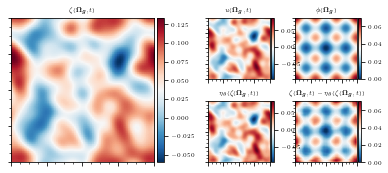

In [27]:
fig = plot_run(linear_run)

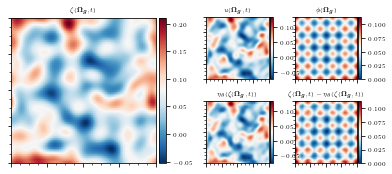

In [28]:
fig = plot_run(nonlinear_run)

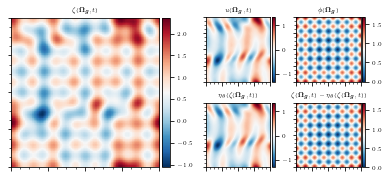

In [29]:
fig = plot_run(kolmogorov_run)

## **Plot Kinetic Energy Recovery**

In [30]:
def mu_ke(data: np.ndarray) -> np.ndarray:
        
    ke = 0.5 * oe.contract('b t u i j -> b t i j', data ** 2)[:, 0, ...]
    mu_ke = einops.reduce(ke, 'b i j -> b', np.mean)
    
    return mu_ke

In [31]:
def plot_run_ke(run: Run):
    
    u_original, u_corrupted, u_predictions, _ = load_data(run.inference_path)
    
    fig = plt.figure(figsize=(12, 5), facecolor='white')
    ax = fig.gca()

    ax.plot(mu_ke(u_original), 'c-', linewidth=2, label=r'$\text{KE}(u)$')
    ax.plot(mu_ke(u_corrupted), 'k-', linewidth=2, label=r'$\text{KE}(\zeta)$')
    ax.plot(mu_ke(u_predictions), 'r--', dashes=(4, 2), linewidth=2, label=r'$\text{KE}(\eta_{\theta}(\zeta))$')

    plt.legend(fontsize=12, loc='upper right')

    # ax.set_xlim(0, u_original.shape[0])
    # ax.set_ylim(0.6, 1.8)

    ax.set_xlabel('Time-step', fontsize=14)
    ax.set_ylabel('Kinetic Energy', fontsize=14)
    
    return fig

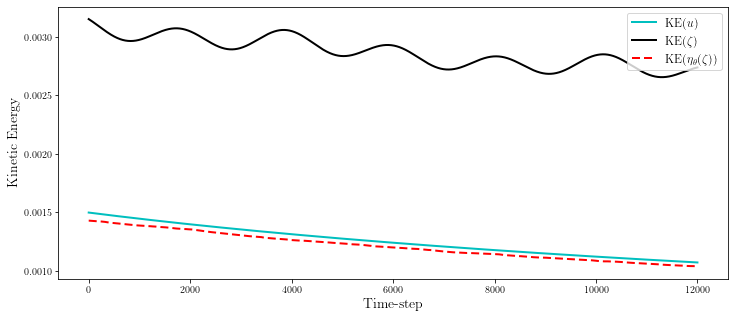

In [32]:
fig = plot_run_ke(linear_run)

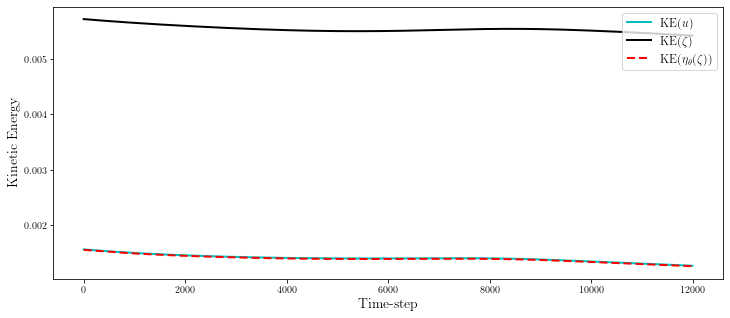

In [33]:
fig = plot_run_ke(nonlinear_run)

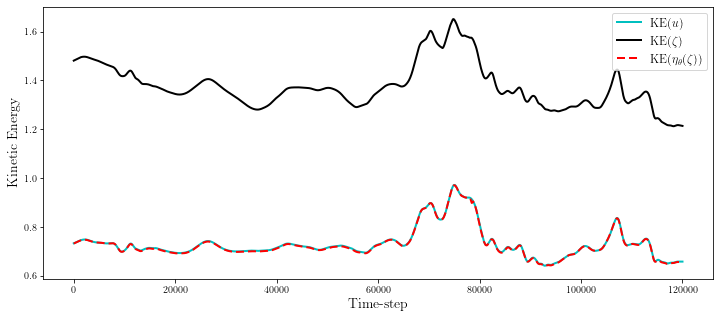

In [34]:
fig = plot_run_ke(kolmogorov_run)